In [1]:
#import seaborn as sns
import pandas as pd
import cooler
from hicool.process import txt2scool

In [12]:
meta_path = "/store/zlwang/Workspace/Myproject/hicool/data/DipC2019_raw_meta.csv"
chromsizes = "/store/zlwang/Workspace/Myproject/hicool/data/mm10.chrom.sizes"
chroms = [1,3]
positions = [2,4]
#resolutions = [1000000,100000,50000,10000,5000,1000]
resolutions = [1000000,100000,10000]
prefix = "DipC2019"
nproc = 40
save_dir = "/store/zlwang/Workspace/Myproject/hicool/data/DipC2019"

In [8]:
file_list = pd.read_csv(meta_path).iloc[:,0]
chrom_list = pd.read_csv(chromsizes,sep="\t",header=None)[0].tolist()

In [ ]:
for res in resolutions:
    txt2scool(file_list,chrom_list,chromsizes,prefix,nproc=nproc,chroms=chroms,positions=positions,resolution=int(res),save_dir=save_dir)


In [14]:
scool = "/store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000.scool"

In [ ]:
from hicool.function.features import fast_oe
from hicool.process import AutoLoad
cell_list = AutoLoad(scool).load_scool_cells()
for cell in cell_list :
    fast_oe(cell,store=True)

100%|██████████| 269/269 [00:11<00:00, 24.17it/s]


235 passed quality control, with more than 10000 contacts, more than 10000 nonzero bins , intra contacts percentage more than 50.0 %.
Saving quality control figures  to /store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000_qc.png
Saving quality control cells results to /store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000_qc.scool and  /store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000_qc_meta.csv
Saving quality controlled cells stats to /store/zlwang/Workspace/Myproject/hicool/data/DipC2019/DipC2019_100000_qc_stats.png


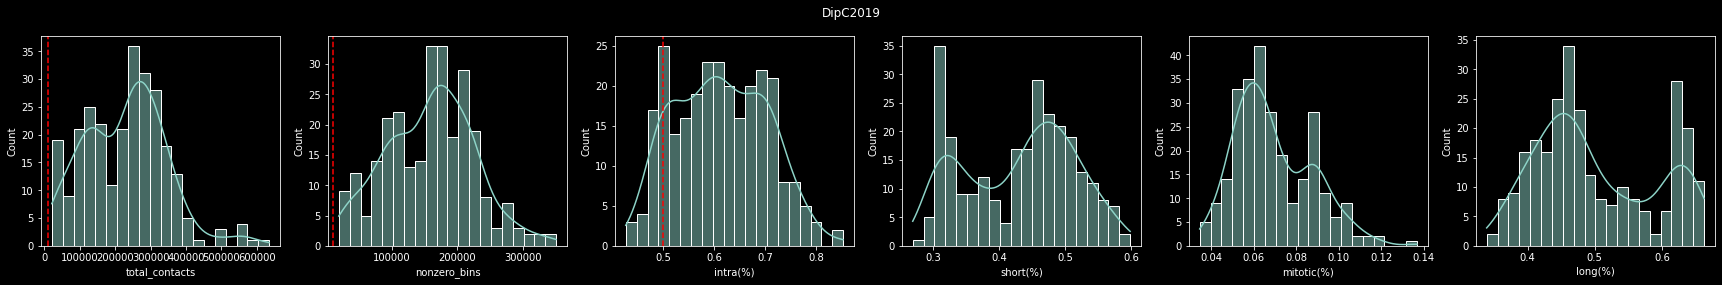

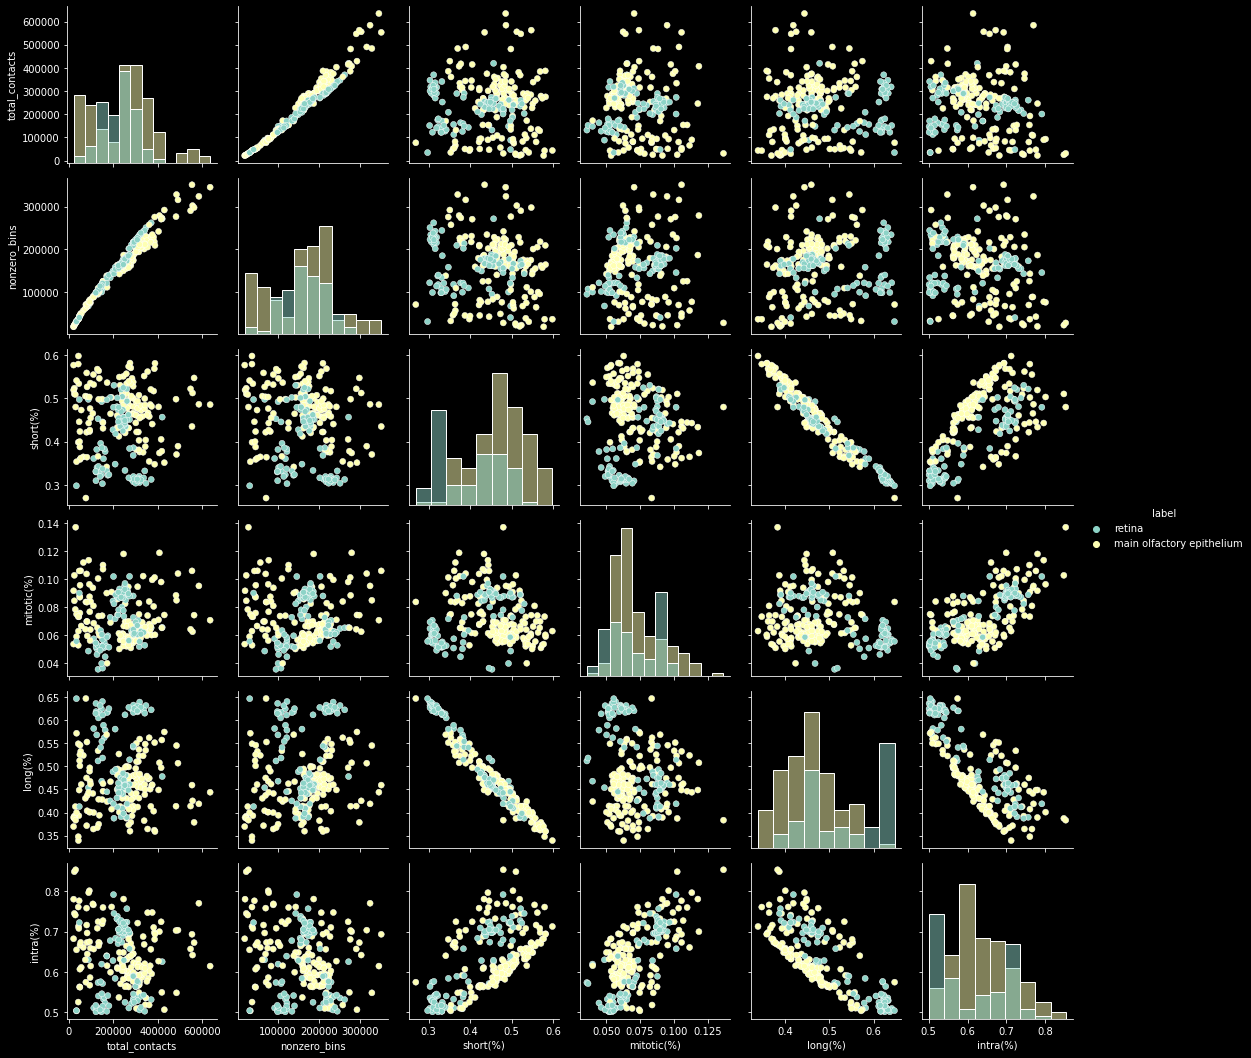

In [17]:
from hicool.process import plot_stats, quality_control
qual_scool,qual_path = quality_control(scool,meta_path)
g = plot_stats(qual_path)

In [20]:
scool_qc = scool.replace(".scool","_qc.scool")
cell_list = AutoLoad(scool_qc).load_scool_cells()
clr = cooler.Cooler(cell_list[1])

In [25]:
mat = clr.matrix(field="OE",balance = False).fetch("chr1")

In [48]:
clr.matrix(as_pixels=True,balance=False).fetch("chr1","chr1")

,bin1_id,bin2_id,count
0,30,30,6
1,30,31,2
2,30,34,2
3,30,35,1
4,30,53,1
...,...,...,...
7571,1949,1950,1
7572,1949,1951,1
7573,1950,1950,1
7574,1951,1951,6


In [49]:
clr.matrix(as_pixels=True,balance=False,field = "OE").fetch("chr1","chr1")


,bin1_id,bin2_id,OE
0,30,30,2.727788
1,30,31,2.625256
2,30,34,18.731707
3,30,35,10.720671
4,30,53,67.892860
...,...,...,...
7571,1949,1950,1.312628
7572,1949,1951,4.124464
7573,1950,1950,0.454631
7574,1951,1951,2.727788


<AxesSubplot:>

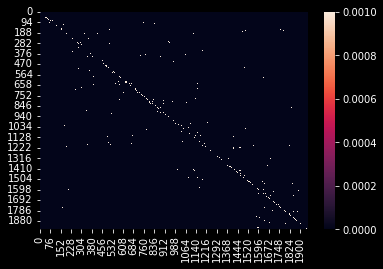

In [30]:
import seaborn as sns 
import numpy as np
sns.heatmap(mat,vmax = 0.001)

In [50]:
from hicool.function.dataloader import load_scool_adj
mats = load_scool_adj(scool)

In [51]:
mats_qc = load_scool_adj(scool_qc)

In [100]:
mats_qc.shape

torch.Size([235, 1955, 1955])

In [64]:
meta_qc = pd.read_csv(qual_path)
meta_qc.label

0      retina
1      retina
2      retina
3      retina
4      retina
        ...  
230    retina
231    retina
232    retina
233    retina
234    retina
Name: label, Length: 235, dtype: object

In [58]:
from sklearn.decomposition import PCA
pc = PCA(3).fit_transform(mats_qc[1])

In [169]:
from hicool.function.similarity import _all_strata
stratas = _all_strata(cell_list)

In [170]:
concat_strata = stratas[0]
for i in stratas[1:]:
    concat_strata = np.concatenate((concat_strata,i),axis = 1)

In [149]:
from sklearn  import  preprocessing
concat_strata 
norm_strata =  preprocessing.MinMaxScaler().fit_transform(concat_strata)

In [171]:
from hicool.function.decomposition import all_strata
stratas = all_strata(cell_list,concat=True)
concat_strata = stratas
cutoff = np.quantile(concat_strata,0.998)
concat_strata[concat_strata > cutoff] = cutoff
norm_strata =  preprocessing.MinMaxScaler().fit_transform(concat_strata)


In [179]:
def node_degree(pixels):
    p1 = pixels.value_counts('bin1_id') 
    p2 = pixels.value_counts('bin2_id')
    p = p1.add(p2,fill_value = 0)
    return p
def node_strength(pixels):
    # node weighted degree
    p1 = pixels.groupby("bin1_id").sum()['count']
    p2 = pixels.groupby("bin2_id").sum()['count']
    p = p1.add(p2,fill_value = 0)
    return p


<AxesSubplot:>

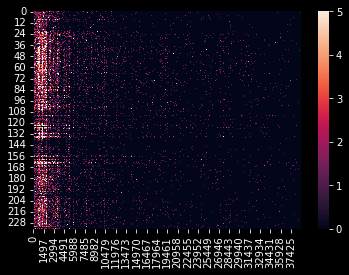

In [153]:
sns.heatmap(concat_strata,vmax = 5)


In [303]:
ns = []
for chrom in clr.chromnames[:-2]:
    nd = []
    for cell in cell_list :
        n = node_strength(cooler.Cooler(cell).matrix(balance=False,as_pixels=True).fetch(chrom)[:]).fillna(0)
        cut_off = n.quantile(0.95)
        n[n>cut_off] = int(cut_off)
        #n /= n.sum()
        nd.append(n)
    node_dg = pd.concat(nd,axis = 1).fillna(0).sort_index()
    ns.append(node_dg)
node_st = pd.concat(ns,axis = 0).fillna(0).sort_index()

In [301]:
cooler.Cooler(cell).matrix(balance=False,as_pixels=True).fetch("chrY")

,bin1_id,bin2_id,count


In [291]:
aa = preprocessing.MinMaxScaler().fit_transform(node_dg)

<AxesSubplot:>

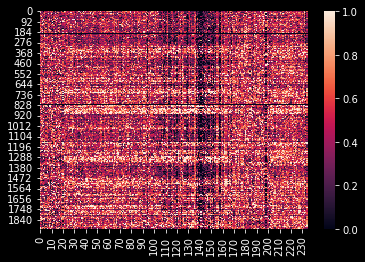

In [283]:
sns.heatmap(aa)

/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

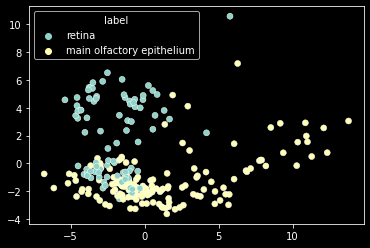

In [292]:
ss = PCA(3).fit_transform(np.array(aa.T)).T
sns.scatterplot(ss[0],ss[1],hue=meta_qc.label)

In [147]:
from sklearn.cluster import KMeans,AgglomerativeClustering
pcs = PCA(10).fit_transform(np.array(concat_strata))
K = KMeans(2)
clf = K.fit_transform(pcs).T


In [308]:
K.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [310]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(lbs,K.labels_)

0.17301507389153167

In [138]:
lbs = ((meta_qc.label == "retina") + 0).to_list()

In [140]:
np.array(lbs)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [134]:
np.corrcoef(K.labels_,lbs)

array([[1.        , 0.50663656],
       [0.50663656, 1.        ]])

/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

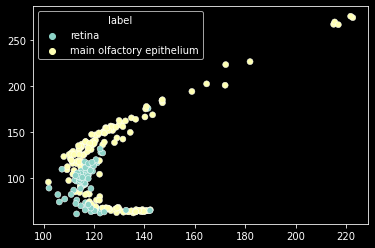

In [125]:
sns.scatterplot(clf[0],clf[1],hue=meta_qc.label)


In [102]:
from hicool.function.decomposition import all_strata

stratas = all_strata(cell_list,field="OE",concat=True)


/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/store/zlwang/anaconda3/envs/hicool/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

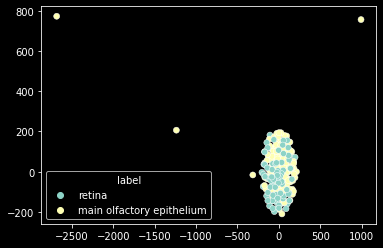

In [114]:
from sklearn.manifold import TSNE

ss = TSNE(3).fit_transform(np.array(stratas)).T
sns.scatterplot(ss[0],ss[1],hue=meta_qc.label)

In [113]:
from umap import umap_